In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal as sig
from scipy import io
from scipy.fftpack import fft, ifft, fftfreq
from scipy.linalg import toeplitz
import scipy.linalg
import math
import os
import pandas as pd
import mne
from scipy.signal import find_peaks

# Obtención de señal



De la base de datos se tienen en cuenta los siguientes parámetros:

* Four signals acquired from maternal abdomen
* Direct electrocardiogram recorded simultaneously from fetal head
* Bandwidth: 1Hz - 150Hz (synchronous sampling of all signals)
* Sampling rate: 1 kHz
* Resolution: 16 bits










In [7]:
path = "C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP señales/abdominal-and-direct-fetal-ecg-database-1.0.0"

In [9]:
EDF_dir = os.path.join(path, 'EDF')
QRS_dir = os.path.join(path, 'QRS')

EDF_files = [f for f in os.listdir(EDF_dir) if os.path.isfile(os.path.join(EDF_dir, f))]
QRS_files = [f for f in os.listdir(QRS_dir) if os.path.isfile(os.path.join(QRS_dir, f))]

QRS_files

[]

In [10]:
edf=[]
qrs=[]
for file in EDF_files:
  file_path = os.path.join(EDF_dir, file)
  data = mne.io.read_raw_edf(file_path)
  edf.append(data)
edf

[]

Los archivos .edf.qrs tienen un formato ilegible. Además, no serán usados en principio.

##Previsualización de señales

In [11]:
edf[0] #son datos tipo RAW

IndexError: list index out of range

In [ ]:
fs=edf[0].info['sfreq'] #frecuencia de muestreo de la señal--> 1000Hz
ts=1/fs
edf[0].ch_names #contienen las cinco derivaciones

['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']

In [ ]:
r1=edf[0].get_data()
r4=edf[1].get_data()
r7=edf[2].get_data()
r8=edf[3].get_data()
r10=edf[4].get_data()

Si bien son 5 muestras distintas, nos enfocaremos en analizar la primera de ellas. El procedimiento es análogo en el resto.

In [ ]:
r1.shape #cada derivación tiene 300000 muestras

(5, 300000)

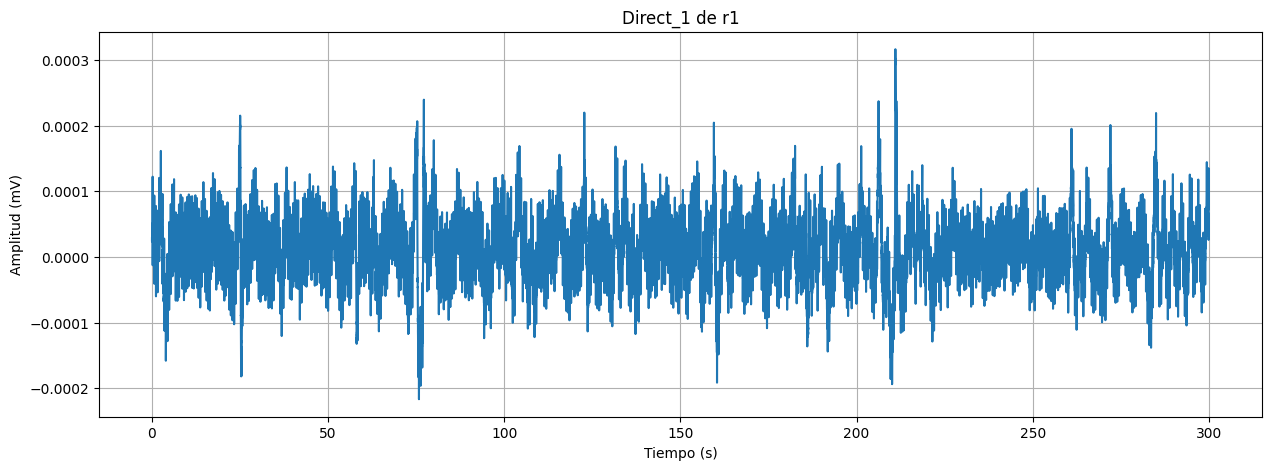

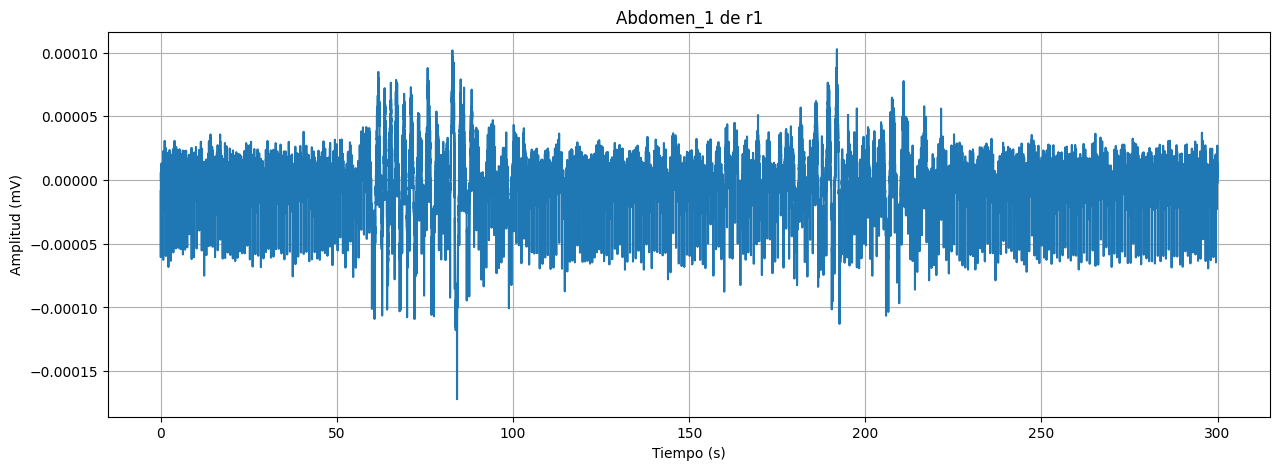

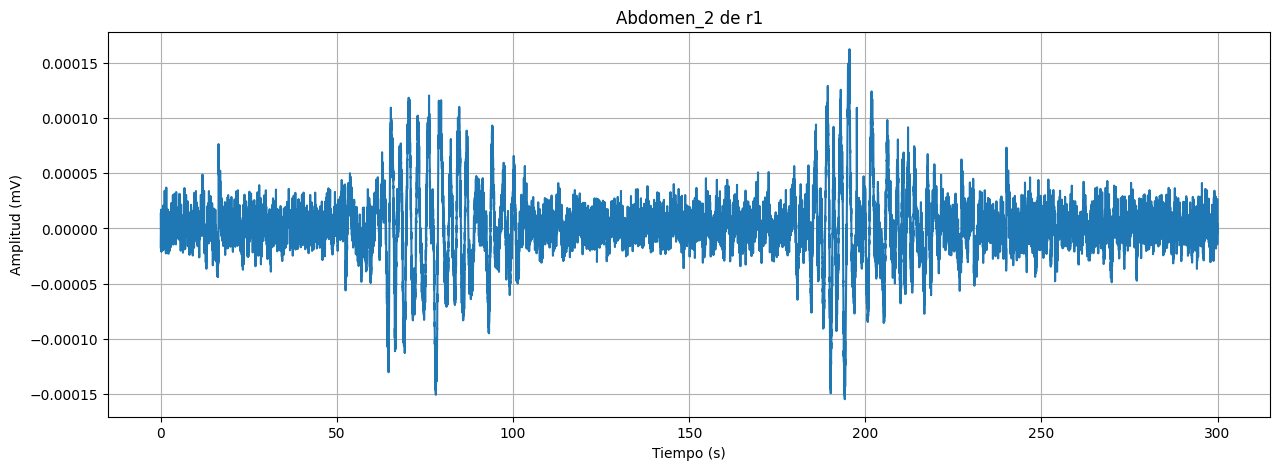

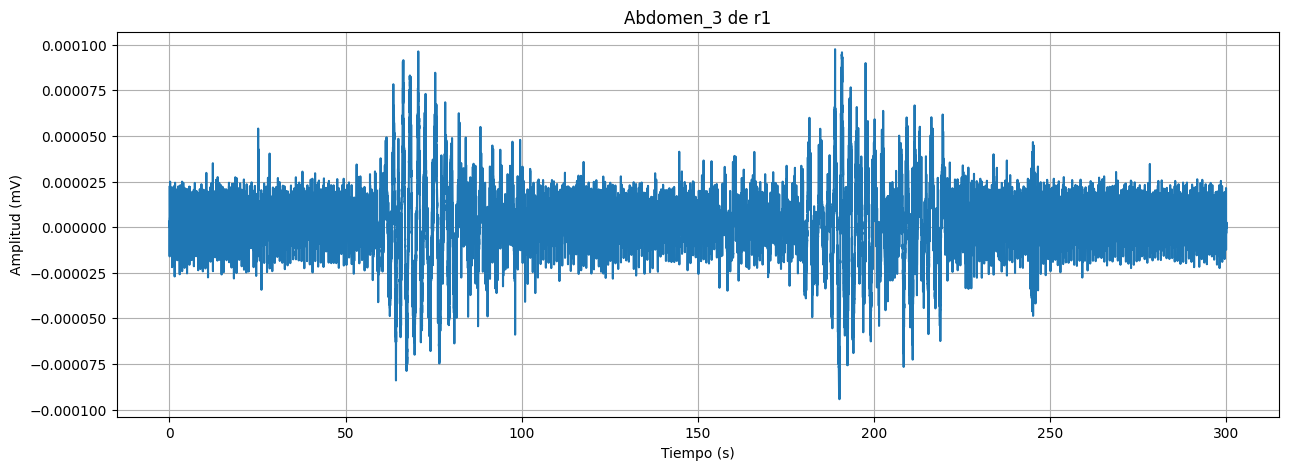

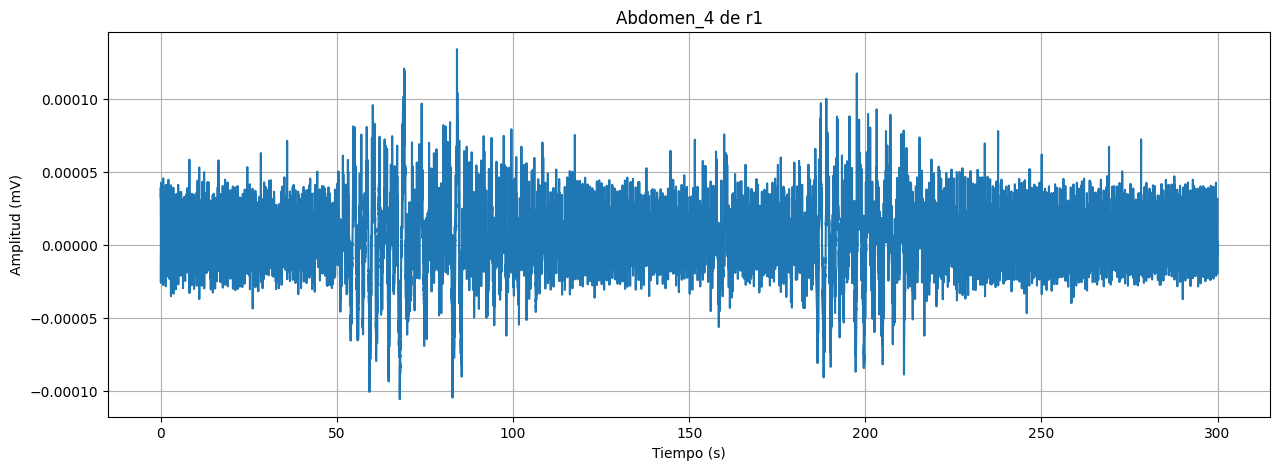

In [ ]:
N=r1.shape[1]
t=np.linspace(0,N/fs,N)
for i in range(5):

  plt.figure(figsize=(15,5))
  plt.plot(t,r1[i])
  plt.xlabel("Tiempo (s)")
  plt.ylabel("Amplitud (mV)")
  plt.title(f"{edf[0].ch_names[i]} de r1")
  plt.grid()
  plt.show()

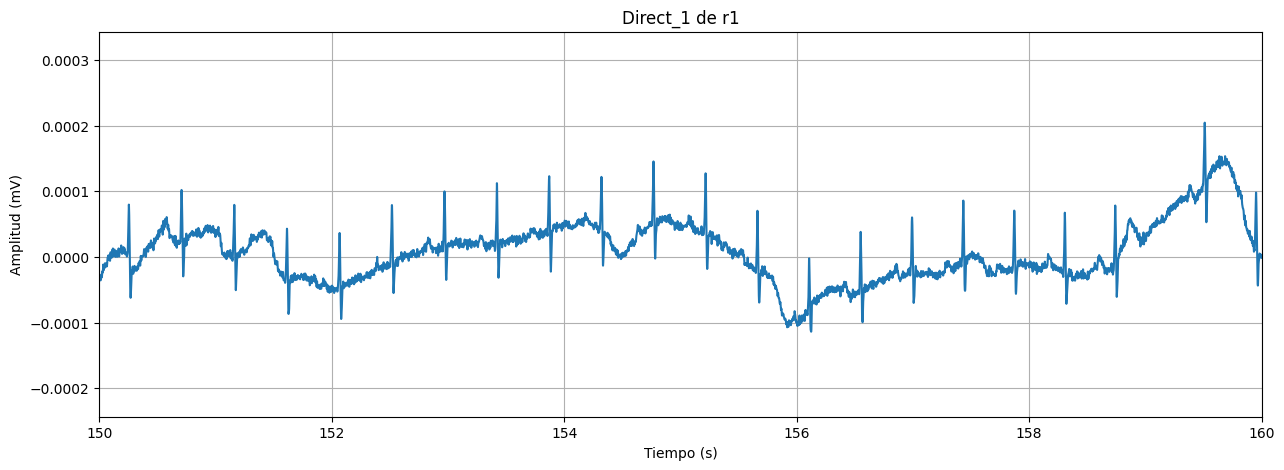

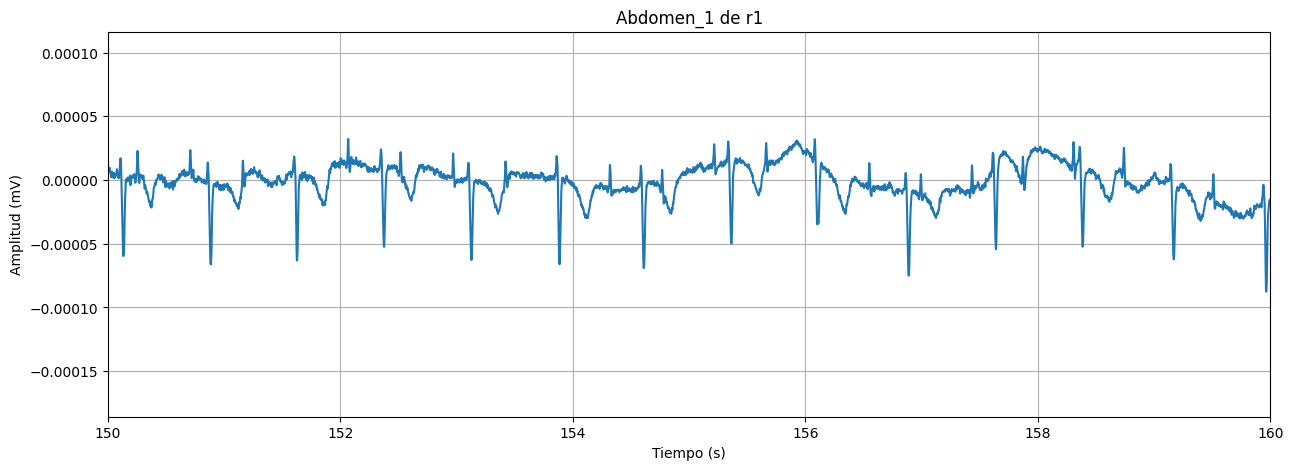

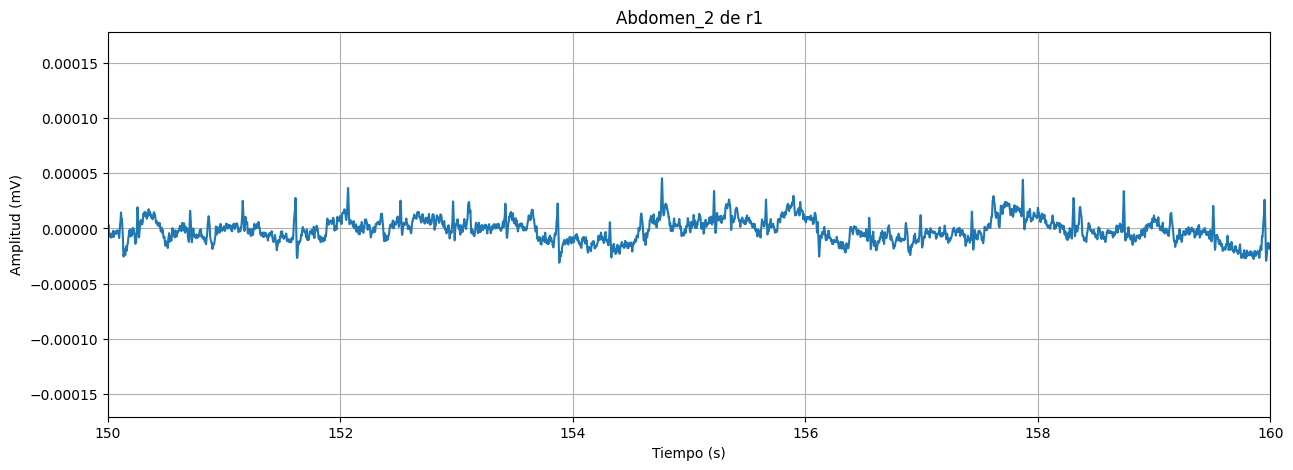

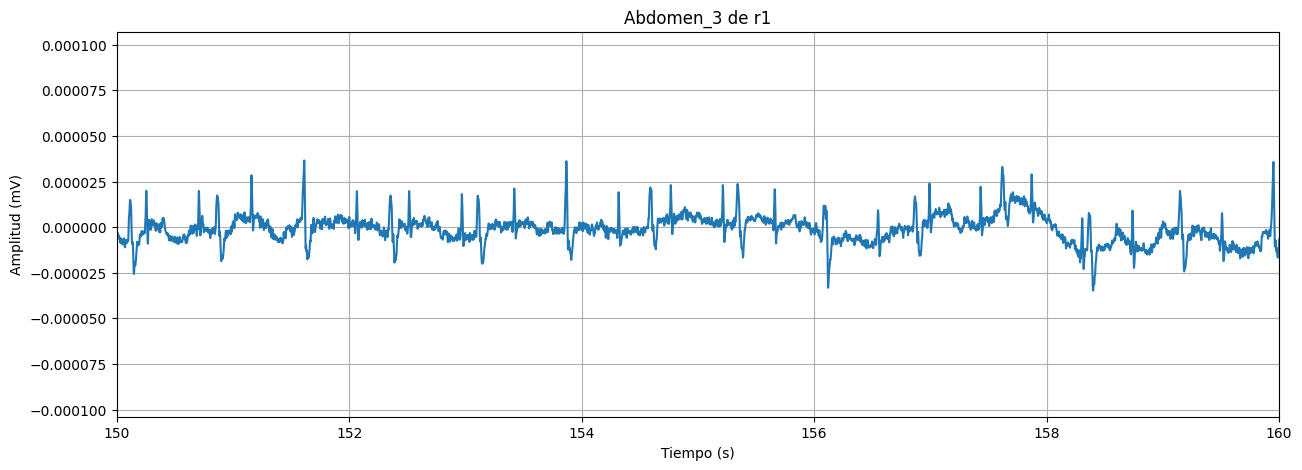

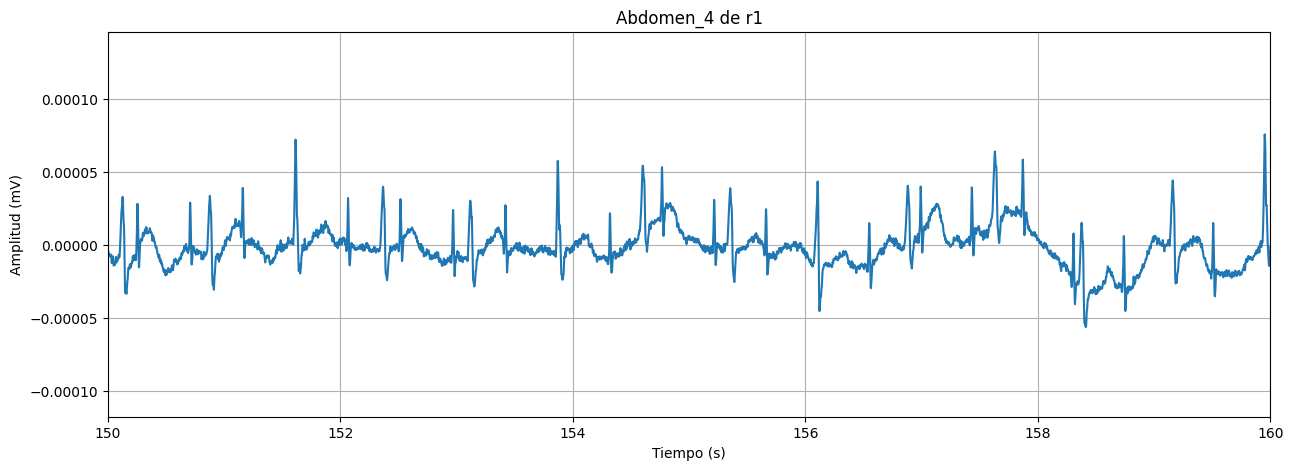

In [ ]:
#tomando un interavalo mas claro de la señal
N=r1.shape[1]
t=np.linspace(0,N/fs,N)
medias=[]
for i in range(5):
  medias.append(np.mean(r1[i]))
  plt.figure(figsize=(15,5))
  plt.plot(t,r1[i])
  plt.xlabel("Tiempo (s)")
  plt.ylabel("Amplitud (mV)")
  plt.xlim(150,160)
  plt.title(f"{edf[0].ch_names[i]} de r1")
  plt.grid()
  plt.show()

In [ ]:
def psd_welch(signal, N, fs, coc_nfft=5, titulo="", xlim=5):
  nfft=N//coc_nfft
  nperseg=nfft
  fre1, psd1 = sig.welch(signal, fs, nperseg=nperseg, nfft=nfft, window='hamming', noverlap=nperseg//2)
  plt.figure(figsize=(15,5))
  plt.plot(fre1,psd1)
  plt.xlabel("Frecuencia (Hz)")
  plt.ylabel("PSD")
  plt.title(f"Periodograma de {titulo}")
  plt.grid()
  plt.xlim(0,xlim)
  plt.show()
  return fre1, psd1

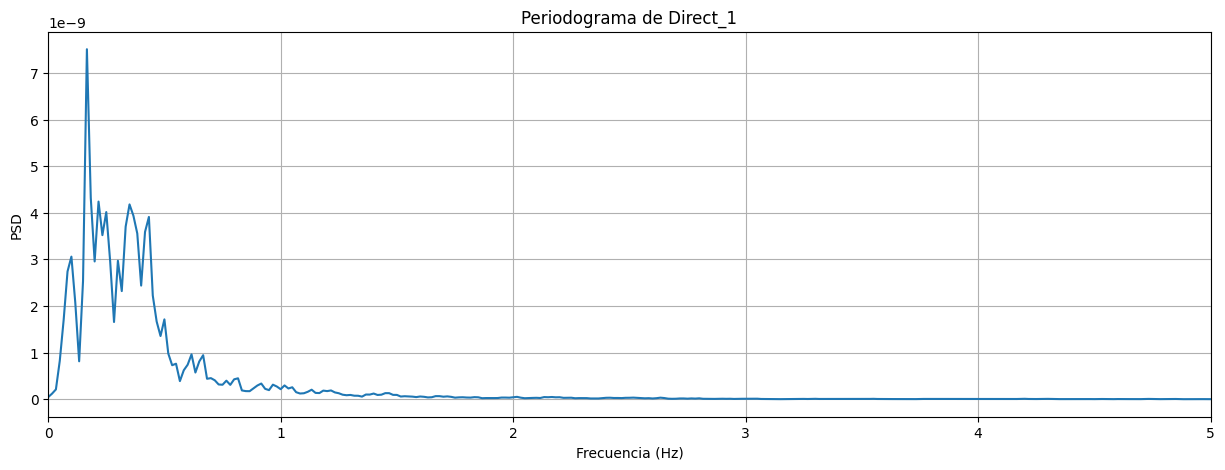

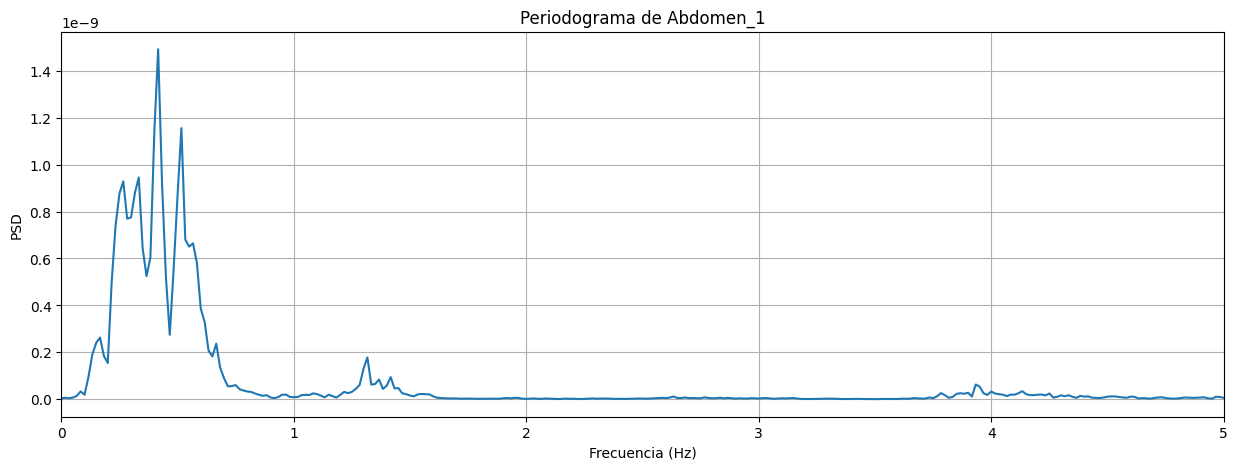

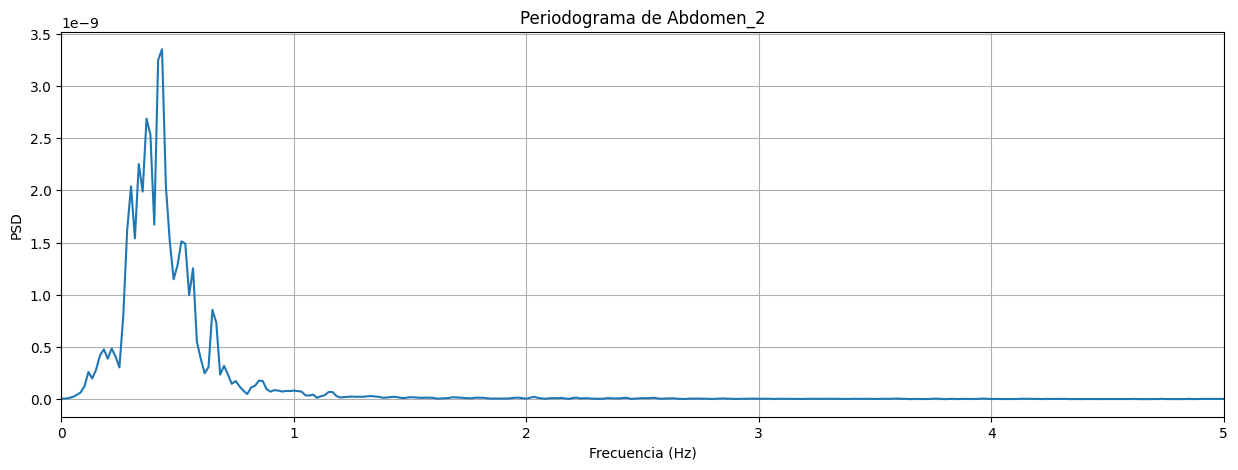

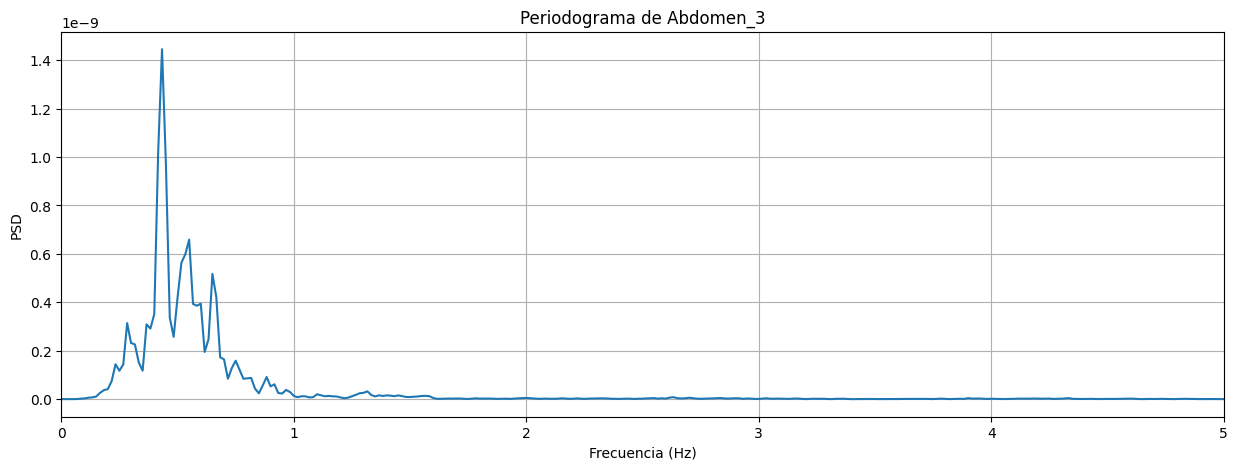

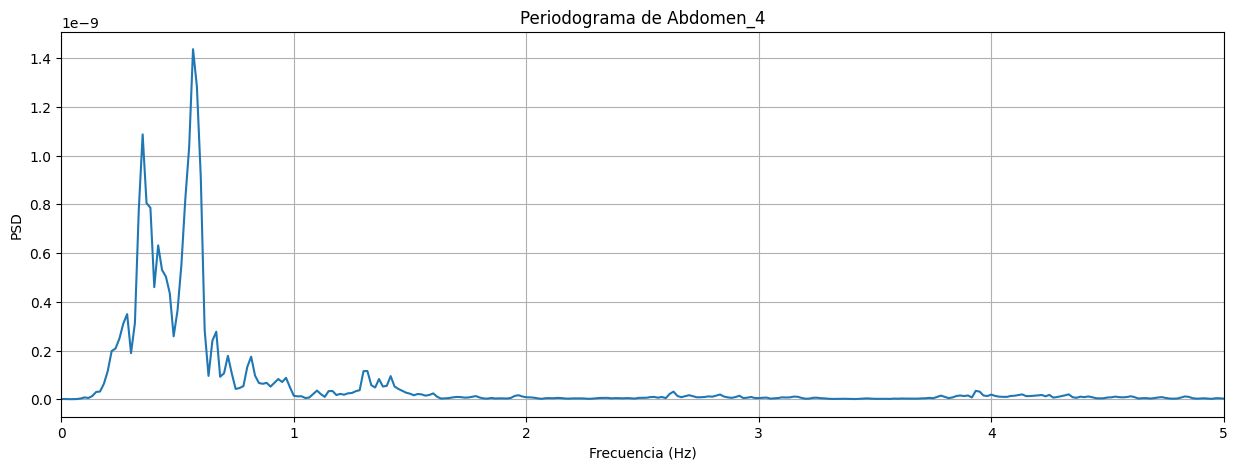

In [ ]:
titulos=["Direct_1", "Abdomen_1", "Abdomen_2", "Abdomen_3", "Abdomen_4"]
for i in range(5):
  psd_welch(r1[i],N,fs, titulo=titulos[i])

En todas las señales, el PSD se acumula entre [0Hz, 3Hz]

#Prefiltrado de la señal

Vemos primeramente que muchas de las señales cuentan con ruido fisiológico de deriva. Es por eso que buscamos aplicar un pasa altos con frecuencia de corte determinada.

In [ ]:
def pasaaltos(signal, order = 5, wn = 0.5 ):
  [b,a] = sig.butter(order, wn, btype = 'highpass', output = 'ba', fs = fs)
  signal_filt = sig.filtfilt(b, a, signal)
  return signal_filt

Probamos con 0.5 Hz como se vió en la teoría:

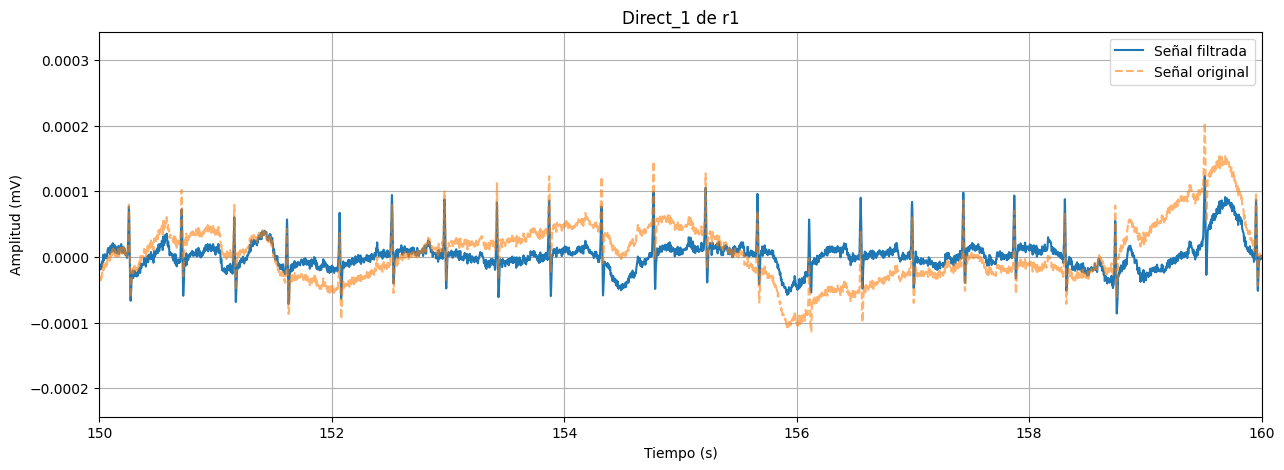

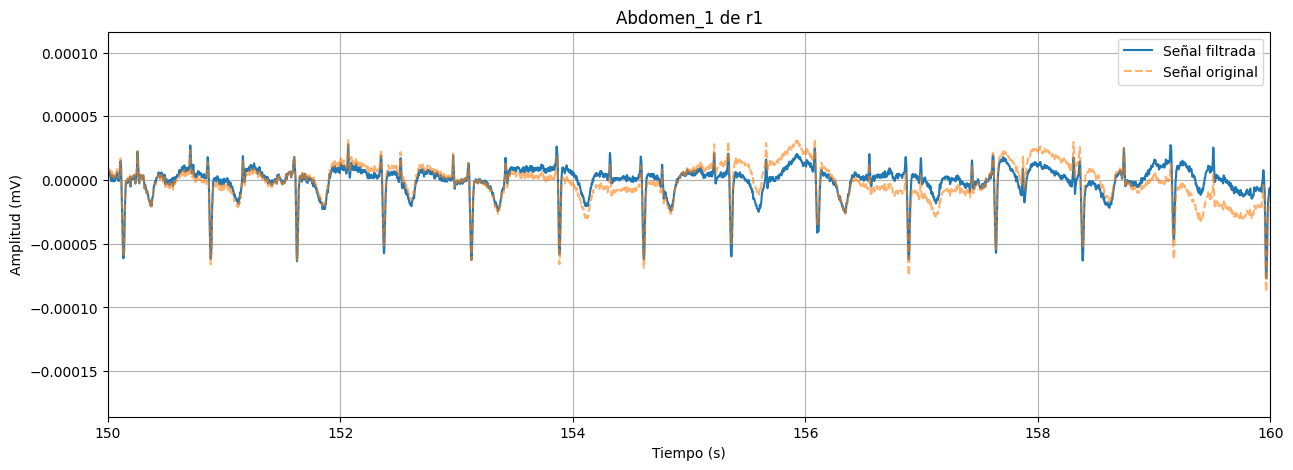

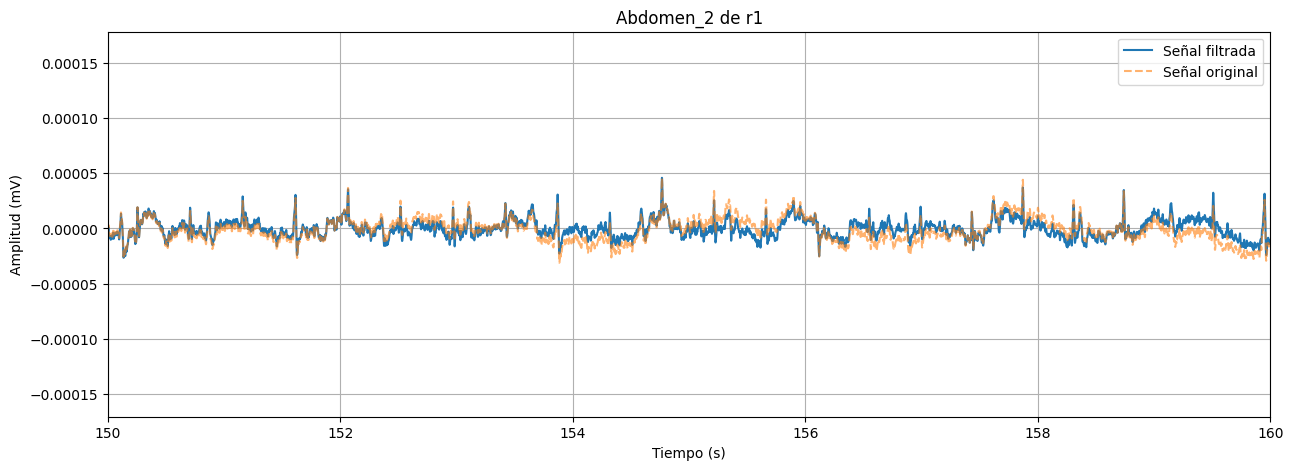

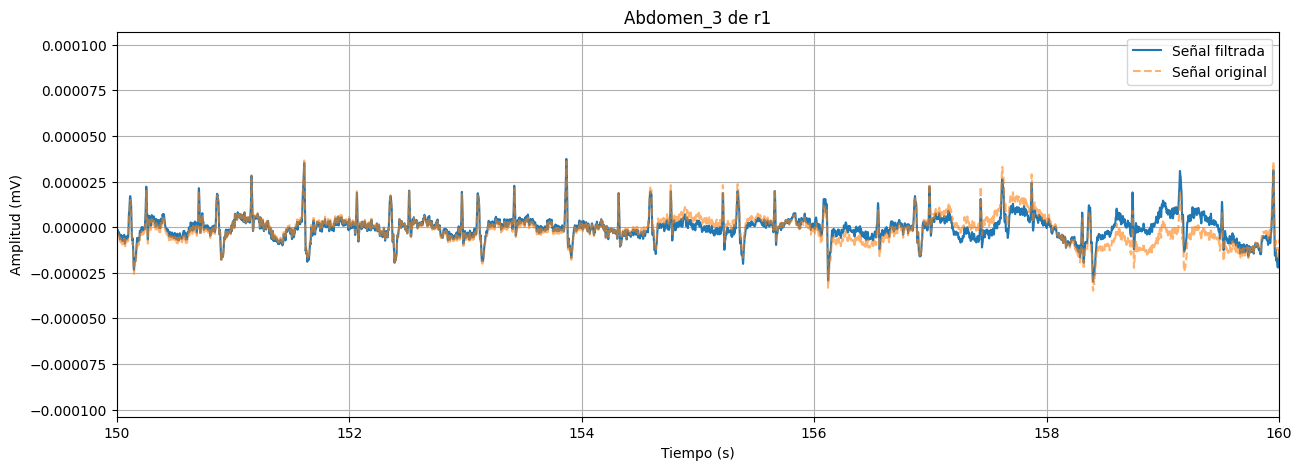

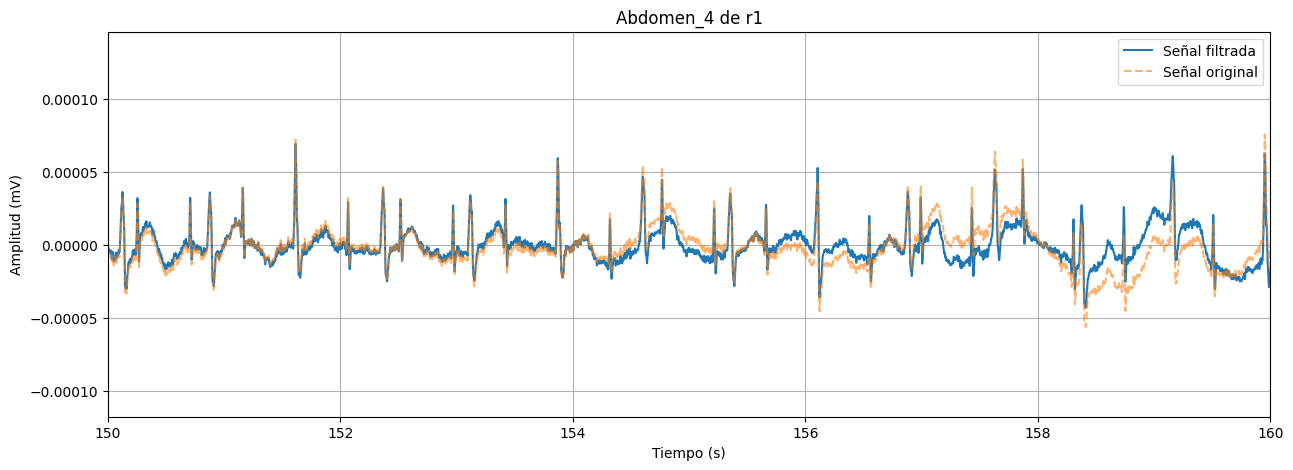

Media sin filtrar| Media filtrada
3.404265278300035e-07 | 9.8838197132001e-09
3.170481711054064e-08 | 1.5003278237452106e-08
2.8496768159598344e-08 | 1.2497574613653647e-08
5.2547801815914275e-08 | 1.3555728694712114e-08
5.981291267270845e-08 | 1.1437733156433051e-08


In [ ]:
r1_filt=[]
medias_filt=[]
for i in range(5):
  r1_filt.append(pasaaltos(r1[i], order=5,wn=0.5))
  medias_filt.append(np.mean(r1_filt[i]))


for i in range(5):
  plt.figure(figsize=(15,5))
  plt.plot(t,r1_filt[i], label= "Señal filtrada")
  plt.plot(t,r1[i], label = "Señal original", linestyle= "--", alpha = 0.6)
  plt.xlabel("Tiempo (s)")
  plt.ylabel("Amplitud (mV)")
  plt.legend()
  plt.title(f"{edf[0].ch_names[i]} de r1")
  plt.xlim(150,160)
  plt.grid()
plt.show()

print("Media sin filtrar| Media filtrada")
for i in range(5):
  print(f"{abs(medias[i])} | {abs(medias_filt[i])}")


Como se puede ver, se redujo en todos los casos la deriva significativamente. Principalmente, en la primera derivación (directa), que es la más suceptible al ruido fisiológico. Ahora buscamos aplicar un pasabajos para eliminar ruidos de altas frecuencias.

In [ ]:
def pasabajos(signal, order = 5, wn = 50 ):

  [b,a] = sig.butter(order, wn, btype = 'lowpass', output = 'ba', fs = fs)
  sig_filt = sig.filtfilt(b, a, signal)
  return sig_filt


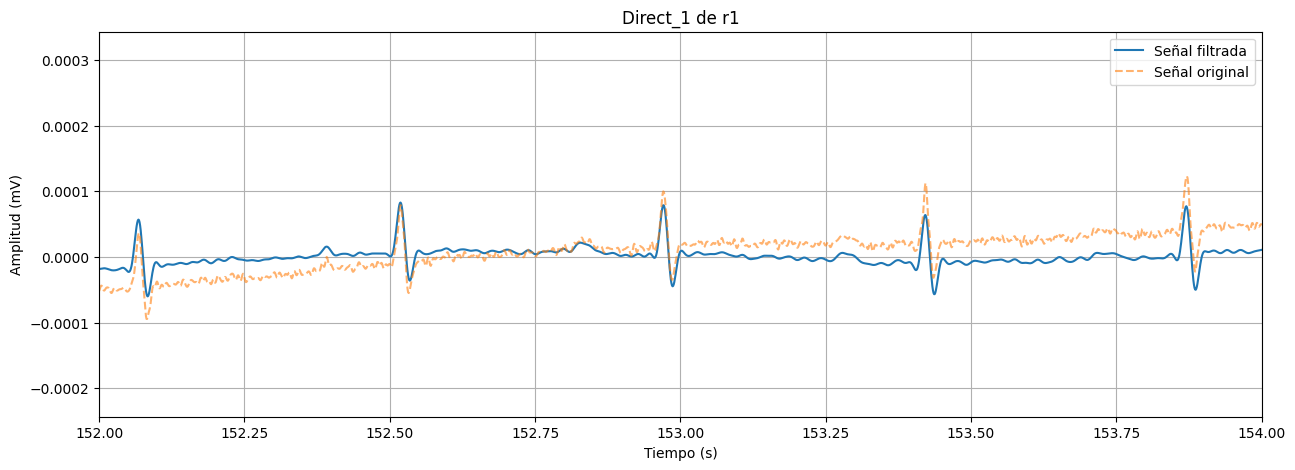

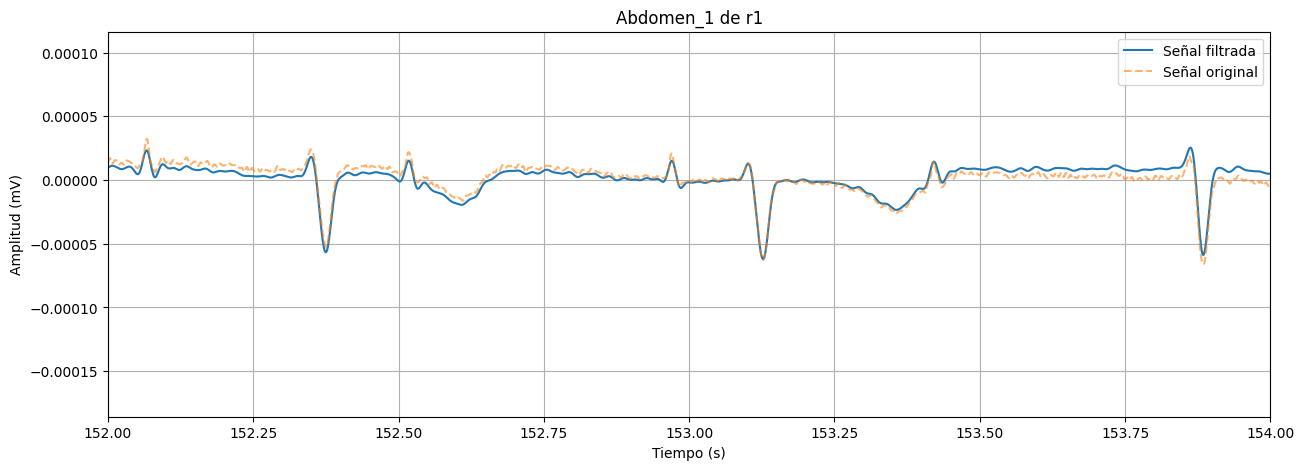

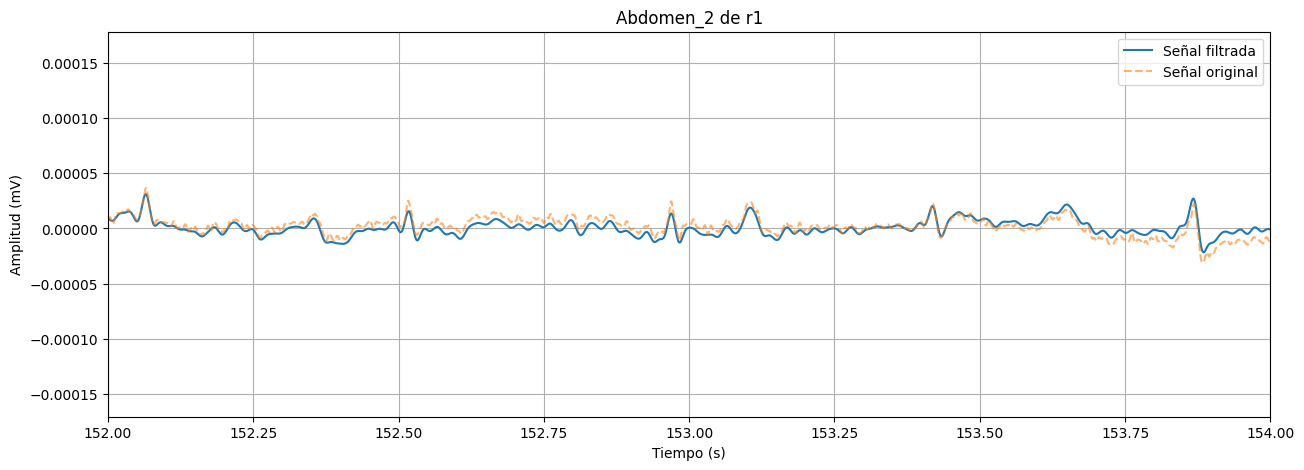

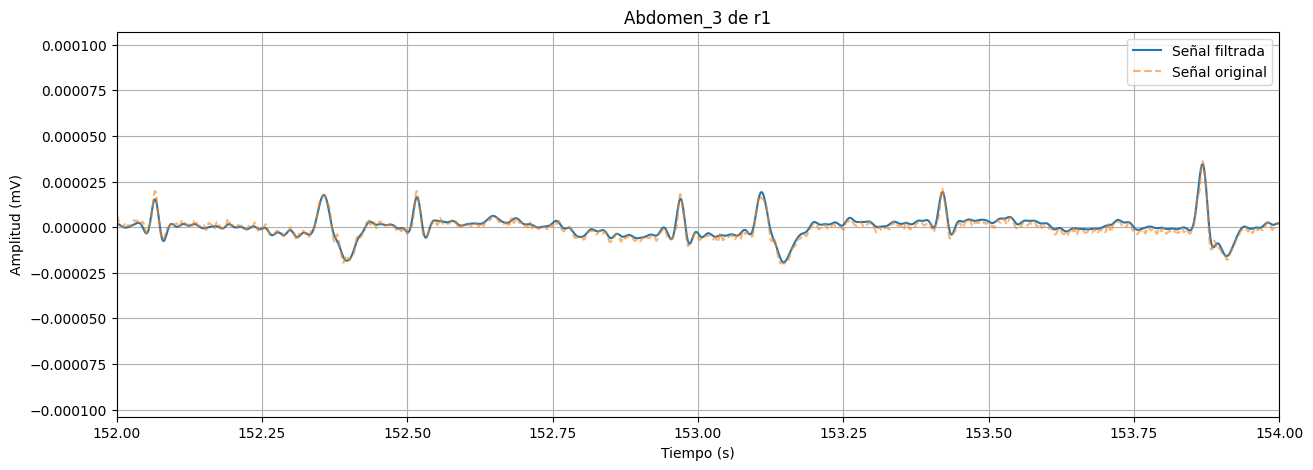

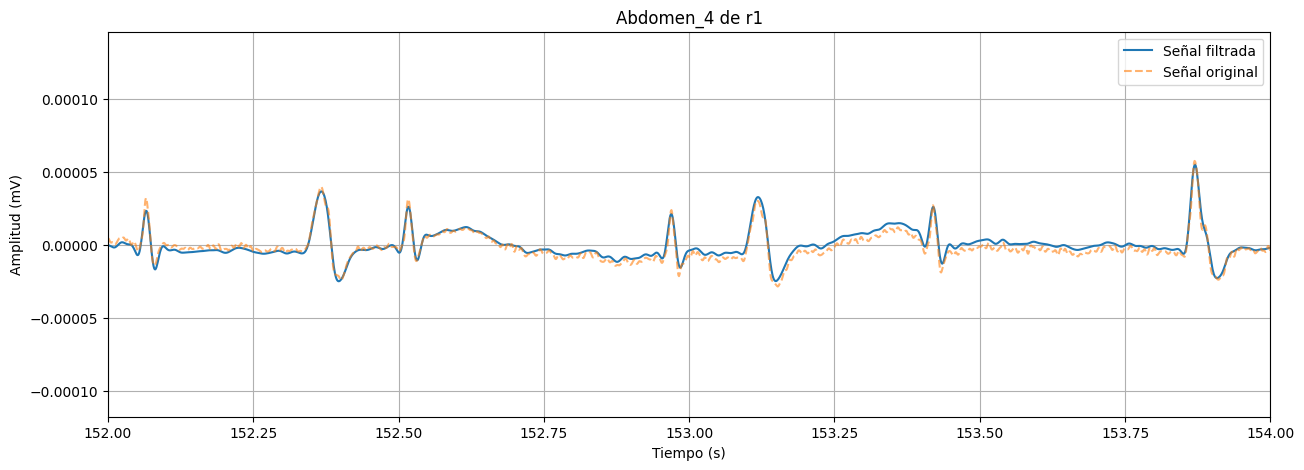

In [ ]:
for i in range(5):
  r1_filt[i]=pasabajos(r1_filt[i])

for i in range(5):
  plt.figure(figsize=(15,5))
  plt.plot(t,r1_filt[i], label= "Señal filtrada")
  plt.plot(t,r1[i], label = "Señal original", linestyle= "--", alpha = 0.6)
  plt.xlabel("Tiempo (s)")
  plt.ylabel("Amplitud (mV)")
  plt.legend()
  plt.title(f"{edf[0].ch_names[i]} de r1")
  plt.xlim(152,154)
  plt.grid()
plt.show()

El resultado final es una señal más limpia y sin tanta deriva.

#Filtro óptimo

Para eliminar ahora el ECG materno (MECG), buscamos implementar filtros vistos a lo largo de la materia para aislar el ECG fetal (FECG). Lo más sencillo sería trabajar con filtros óptimos o adaptativos, sin embargo, no contamos con d[n], es decir, la señal deseada a la cual queremos llegar.

In [ ]:
x=[r1_filt[1],r1_filt[2],r1_filt[3],r1_filt[4]]
w=np.zeros(len(x))


En el paper se utiliza una descomposicion en valores singulares generalizada para ponderar las señales. Sin embargo, no se aclara el como ni el criterio. Los valores singulares dan una idea de la energía de la señal, y se puede asumir que las señales poseen mayormente energía materna, por lo que se les asignara mas peso a ellas:

In [ ]:
energias=[]

for i in range(len(x)):
  energias.append(np.sum(np.square(x[i])))
print(f"energias {energias}")

suma_total_enegrias=np.sum(energias)
for i in range(len(energias)):
  w[i]=energias[i]/suma_total_enegrias
print(f"pesos {w}")


energias [5.6828726837078946e-05, 5.9243612562631074e-05, 3.501127085529095e-05, 6.375396743683595e-05]
pesos [0.26451949 0.27576001 0.16296623 0.29675426]


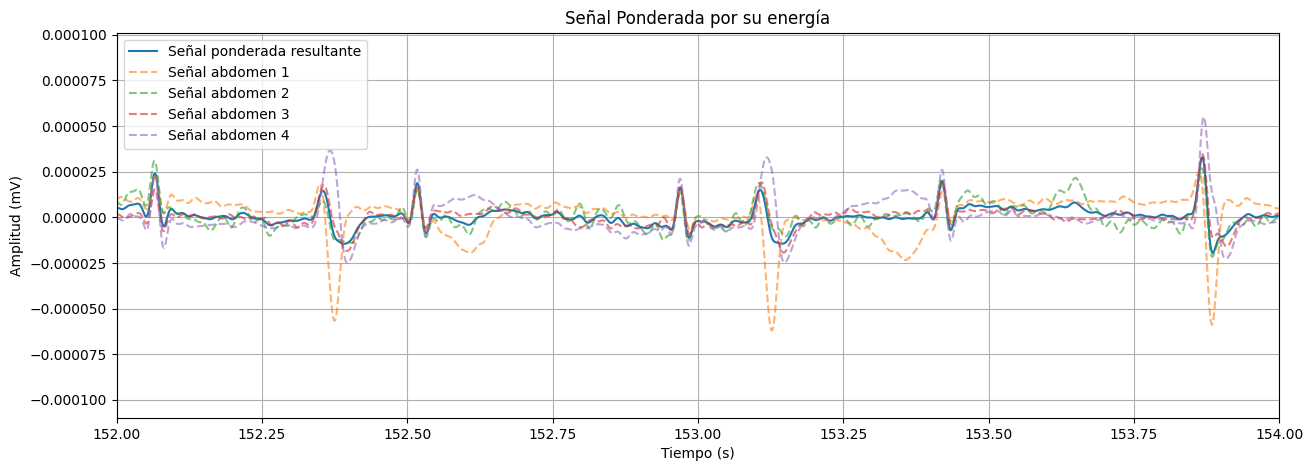

In [ ]:
x_sum=np.zeros(N)
for i in range(len(x)):
  x_sum=x_sum+w[i]*x[i]
plt.figure(figsize=(15,5))
plt.plot(t,x_sum, label= "Señal ponderada resultante")
plt.plot(t,r1_filt[1], label = "Señal abdomen 1", linestyle= "--", alpha = 0.6)
plt.plot(t,r1_filt[2], label = "Señal abdomen 2", linestyle= "--", alpha = 0.6)
plt.plot(t,r1_filt[3], label = "Señal abdomen 3", linestyle= "--", alpha = 0.6)
plt.plot(t,r1_filt[4], label = "Señal abdomen 4", linestyle= "--", alpha = 0.6)
plt.xlim(152,154)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title(f"Señal Ponderada por su energía")
plt.legend()
plt.grid()
plt.show()

Ahora bien, el agoritmo prosigue en el paper encontrando puntos fiduciales maternos, ponderandolos y encontrando señales resultantes de la resta de estos últimos. Sin embargo, resulta dificil de seguir, ya que muchos criterios no se aclaran y no se ahonda demasiado en la matemática del procedimiento. De igual manera, hay que contrastar que el propósito de los autores era comparar el FECG directo con un postprocesamiento del indirecto, y acercarlo lo más posible.

Se propone de nuestra parte tomar el FECG directo como señal deseada (d[n]) e implementar un filtro óptimo para aislar el FECG del indirecto.

In [ ]:
d=r1_filt[0]
u=x_sum.copy()

In [ ]:
def wiener_hopf(x, d, L):
  #x: entrada     d: deseada      L: cantidad de retrasos (orden del filtro)

  ruu = plt.acorr(x, maxlags=L)[1]
  ruu = ruu[L:-1]

  Ruu = toeplitz(ruu)

  # Chequear condicionamiento de R

  Ruu_inv = scipy.linalg.inv(Ruu)

  rdu = plt.xcorr(x, d, maxlags=L)[1]
  rdu = rdu[L:-1]

  b = Ruu_inv.dot(rdu)

  return b

In [ ]:
b=wiener_hopf(u,d,1000)
filtrada_filtfilt = sig.filtfilt(b, 1, u)


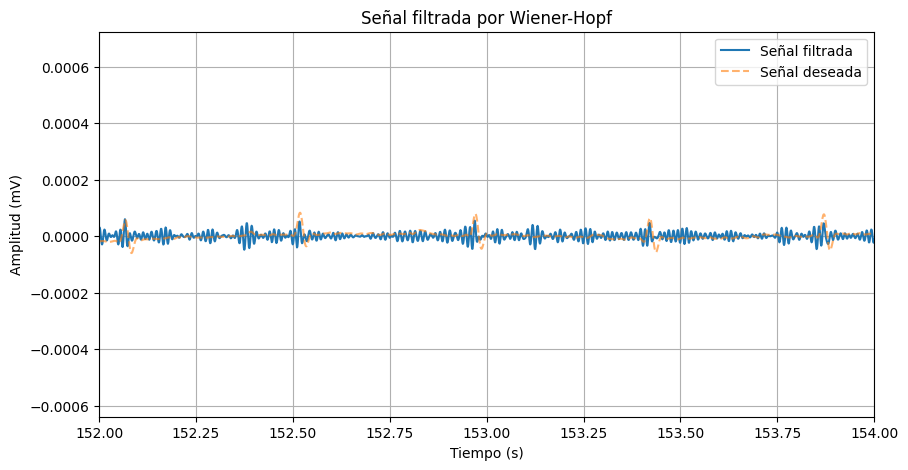

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(t,filtrada_filtfilt, label= "Señal filtrada")
plt.plot(t,d, label = "Señal deseada", linestyle= "--", alpha = 0.6)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.xlim(152,154)
plt.title(f"Señal filtrada por Wiener-Hopf")
plt.legend()
plt.grid()
plt.show()